# The goal of this notebook is to explore the data, both visually and statistically, to gain insights that will be useful when performing analysis.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from scipy import stats, nanmean
import statistics
import math

pd.options.display.max_columns = 5000


# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")



## We start by importing the cleaned dataset that we created earlier.

In [3]:
players = pd.read_csv(r'C:\Users\Evan\Desktop\Capstone_Project\clean_train.csv', index_col='Unnamed: 0')

In [4]:
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682154 entries, 0 to 682153
Data columns (total 62 columns):
GameId                    682154 non-null int64
PlayId                    682154 non-null int64
Team                      682154 non-null object
X                         682154 non-null float64
Y                         682154 non-null float64
S                         682154 non-null float64
A                         682154 non-null float64
Dis                       682154 non-null float64
Orientation               682131 non-null float64
Dir                       682126 non-null float64
DisplayName               682154 non-null object
JerseyNumber              682154 non-null int64
Season                    682154 non-null int64
YardLine                  682154 non-null int64
Quarter                   682154 non-null int64
GameClock                 682154 non-null float64
PossessionTeam            682154 non-null object
Down                      682154 non-null int64
Distan

In [5]:
players.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,HomePossession,OffensePlayer,Field_eq_Possession,HomeField,Formation_ACE,Formation_EMPTY,Formation_I_FORM,Formation_JUMBO,Formation_PISTOL,Formation_SHOTGUN,Formation_SINGLEBACK,Formation_WILDCAT,PlayerBMI,TimeDelta,PlayerAge,IsRusher,YardsLeft
0,2017090700,20170907000118,away,46.09,18.49,1.69,1.13,0.40,278.01,182.82,Eric Berry,29,2017,35,1,854.0,NE,3,2,0,0,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",False,2017-09-08 00:44:06,2017-09-08 00:44:05,8,72,212,1988-12-29 00:00:00,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,False,1.0,63.0,77.0,8.0,1.25,True,False,True,True,0,0,0,0,0,1,0,0,28.749228,1.0,28.692760,False,65
1,2017090700,20170907000118,away,45.33,20.69,0.42,1.35,0.01,332.39,161.30,Allen Bailey,97,2017,35,1,854.0,NE,3,2,0,0,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",False,2017-09-08 00:44:06,2017-09-08 00:44:05,8,75,288,1989-03-25 00:00:00,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,False,1.0,63.0,77.0,8.0,1.25,True,False,True,True,0,0,0,0,0,1,0,0,35.993600,1.0,28.457305,False,65
2,2017090700,20170907000118,away,46.00,20.13,1.22,0.59,0.31,356.99,157.27,Justin Houston,50,2017,35,1,854.0,NE,3,2,0,0,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",False,2017-09-08 00:44:06,2017-09-08 00:44:05,8,75,270,1989-01-21 00:00:00,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,False,1.0,63.0,77.0,8.0,1.25,True,False,True,True,0,0,0,0,0,1,0,0,33.744000,1.0,28.629790,False,65
3,2017090700,20170907000118,away,48.54,25.63,0.42,0.54,0.02,0.23,254.36,Derrick Johnson,56,2017,35,1,854.0,NE,3,2,0,0,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",False,2017-09-08 00:44:06,2017-09-08 00:44:05,8,75,245,1982-11-22 00:00:00,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,False,1.0,63.0,77.0,8.0,1.25,True,False,True,True,0,0,0,0,0,1,0,0,30.619556,1.0,34.795430,False,65
4,2017090700,20170907000118,away,50.68,17.91,1.82,2.43,0.16,347.37,195.69,Ron Parker,38,2017,35,1,854.0,NE,3,2,0,0,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",False,2017-09-08 00:44:06,2017-09-08 00:44:05,8,72,206,1987-08-17 00:00:00,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,False,1.0,63.0,77.0,8.0,1.25,True,False,True,True,0,0,0,0,0,1,0,0,27.935571,1.0,30.061685,False,65


# The first thing we want to do is to reshape the dataframe so that each row is a single play. This way we can compare and find trends across plays.

In [6]:
players = players.sort_values(by=['PlayId', 'OffensePlayer', 'IsRusher'])

# Select only non-categorical features, so we can use standard deviation to find unique player features
cat_features = []
for col in players.columns:
    if players[col].dtype =='object':
        cat_features.append(col)
        
non_cat_features = players.drop(cat_features, axis=1)

In [7]:
# Find unique player features
players_col = []
for col in non_cat_features.columns:
    if non_cat_features[col][:22].std()!=0:
        players_col.append(col)

# Position is a string so it doesn't have a standard deviation, but it is unique to each player, so we still want it in the data frame
players_col.append('Position')       
players_col

['X',
 'Y',
 'S',
 'A',
 'Dis',
 'Orientation',
 'Dir',
 'JerseyNumber',
 'PlayerHeight',
 'PlayerWeight',
 'OffensePlayer',
 'PlayerBMI',
 'PlayerAge',
 'IsRusher',
 'Position']

In [8]:
# Reshape the data so each row is a single play
plays = np.array(players[players_col]).reshape(-1, len(players_col)*22)

In [9]:
# Generate the column names
player_features = []

for i in range(1,23):
    for col in players_col:
        player_features.append(col+'_'+str(i))  

In [10]:
# Create the new data frame with column names
player_plays_df = pd.DataFrame(plays, columns=player_features)


In [11]:
player_plays_df.head()

,X_1,Y_1,S_1,A_1,Dis_1,Orientation_1,Dir_1,JerseyNumber_1,PlayerHeight_1,PlayerWeight_1,OffensePlayer_1,PlayerBMI_1,PlayerAge_1,IsRusher_1,Position_1,X_2,Y_2,S_2,A_2,Dis_2,Orientation_2,Dir_2,JerseyNumber_2,PlayerHeight_2,PlayerWeight_2,OffensePlayer_2,PlayerBMI_2,PlayerAge_2,IsRusher_2,Position_2,X_3,Y_3,S_3,A_3,Dis_3,Orientation_3,Dir_3,JerseyNumber_3,PlayerHeight_3,PlayerWeight_3,OffensePlayer_3,PlayerBMI_3,PlayerAge_3,IsRusher_3,Position_3,X_4,Y_4,S_4,A_4,Dis_4,Orientation_4,Dir_4,JerseyNumber_4,PlayerHeight_4,PlayerWeight_4,OffensePlayer_4,PlayerBMI_4,PlayerAge_4,IsRusher_4,Position_4,X_5,Y_5,S_5,A_5,Dis_5,Orientation_5,Dir_5,JerseyNumber_5,PlayerHeight_5,PlayerWeight_5,OffensePlayer_5,PlayerBMI_5,PlayerAge_5,IsRusher_5,Position_5,X_6,Y_6,S_6,A_6,Dis_6,Orientation_6,Dir_6,JerseyNumber_6,PlayerHeight_6,PlayerWeight_6,OffensePlayer_6,PlayerBMI_6,PlayerAge_6,IsRusher_6,Position_6,X_7,Y_7,S_7,A_7,Dis_7,Orientation_7,Dir_7,JerseyNumber_7,PlayerHeight_7,PlayerWeight_7,OffensePlayer_7,PlayerBMI_7,PlayerAge_7,IsRusher_7,Position_7,X_8,Y_8,S_8,A_8,Dis_8,Orientation_8,Dir_8,JerseyNumber_8,PlayerHeight_8,PlayerWeight_8,OffensePlayer_8,PlayerBMI_8,PlayerAge_8,IsRusher_8,Position_8,X_9,Y_9,S_9,A_9,Dis_9,Orientation_9,Dir_9,JerseyNumber_9,PlayerHeight_9,PlayerWeight_9,OffensePlayer_9,PlayerBMI_9,PlayerAge_9,IsRusher_9,Position_9,X_10,Y_10,S_10,A_10,Dis_10,Orientation_10,Dir_10,JerseyNumber_10,PlayerHeight_10,PlayerWeight_10,OffensePlayer_10,PlayerBMI_10,PlayerAge_10,IsRusher_10,Position_10,X_11,Y_11,S_11,A_11,Dis_11,Orientation_11,Dir_11,JerseyNumber_11,PlayerHeight_11,PlayerWeight_11,OffensePlayer_11,PlayerBMI_11,PlayerAge_11,IsRusher_11,Position_11,X_12,Y_12,S_12,A_12,Dis_12,Orientation_12,Dir_12,JerseyNumber_12,PlayerHeight_12,PlayerWeight_12,OffensePlayer_12,PlayerBMI_12,PlayerAge_12,IsRusher_12,Position_12,X_13,Y_13,S_13,A_13,Dis_13,Orientation_13,Dir_13,JerseyNumber_13,PlayerHeight_13,PlayerWeight_13,OffensePlayer_13,PlayerBMI_13,PlayerAge_13,IsRusher_13,Position_13,X_14,Y_14,S_14,A_14,Dis_14,Orientation_14,Dir_14,JerseyNumber_14,PlayerHeight_14,PlayerWeight_14,OffensePlayer_14,PlayerBMI_14,PlayerAge_14,IsRusher_14,Position_14,X_15,Y_15,S_15,A_15,Dis_15,Orientation_15,Dir_15,JerseyNumber_15,PlayerHeight_15,PlayerWeight_15,OffensePlayer_15,PlayerBMI_15,PlayerAge_15,IsRusher_15,Position_15,X_16,Y_16,S_16,A_16,Dis_16,Orientation_16,Dir_16,JerseyNumber_16,PlayerHeight_16,PlayerWeight_16,OffensePlayer_16,PlayerBMI_16,PlayerAge_16,IsRusher_16,Position_16,X_17,Y_17,S_17,A_17,Dis_17,Orientation_17,Dir_17,JerseyNumber_17,PlayerHeight_17,PlayerWeight_17,OffensePlayer_17,PlayerBMI_17,PlayerAge_17,IsRusher_17,Position_17,X_18,Y_18,S_18,A_18,Dis_18,Orientation_18,Dir_18,JerseyNumber_18,PlayerHeight_18,PlayerWeight_18,OffensePlayer_18,PlayerBMI_18,PlayerAge_18,IsRusher_18,Position_18,X_19,Y_19,S_19,A_19,Dis_19,Orientation_19,Dir_19,JerseyNumber_19,PlayerHeight_19,PlayerWeight_19,OffensePlayer_19,PlayerBMI_19,PlayerAge_19,IsRusher_19,Position_19,X_20,Y_20,S_20,A_20,Dis_20,Orientation_20,Dir_20,JerseyNumber_20,PlayerHeight_20,PlayerWeight_20,OffensePlayer_20,PlayerBMI_20,PlayerAge_20,IsRusher_20,Position_20,X_21,Y_21,S_21,A_21,Dis_21,Orientation_21,Dir_21,JerseyNumber_21,PlayerHeight_21,PlayerWeight_21,OffensePlayer_21,PlayerBMI_21,PlayerAge_21,IsRusher_21,Position_21,X_22,Y_22,S_22,A_22,Dis_22,Orientation_22,Dir_22,JerseyNumber_22,PlayerHeight_22,PlayerWeight_22,OffensePlayer_22,PlayerBMI_22,PlayerAge_22,IsRusher_22,Position_22
0,46.09,18.49,1.69,1.13,0.4,278.01,182.82,29,72,212,False,28.7492,28.6928,False,SS,45.33,20.69,0.42,1.35,0.01,332.39,161.3,97,75,288,False,35.9936,28.4573,False,DE,46,20.13,1.22,0.59,0.31,356.99,157.27,50,75,270,False,33.744,28.6298,False,DE,48.54,25.63,0.42,0.54,0.02,0.23,254.36,56,75,245,False,30.6196,34.7954,False,ILB,50.68,17.91,1.82,2.43,0.16,347.37,195.69,38,72,206,False,27.9356,30.0617,False,FS,44.94,29.33,1.01,0.32,0.18,51.66,264.99,55,74,252,False,32.3514,26.4751,False,DE,45.89,36.69,1.11,0.83,0.02,2.77,37.41,39

In [12]:
# Select features relevant to the play
remove = ['Team','DisplayName', 'PlayerBirthDate', 'PlayerCollegeName', 'Position']

for feature in players_col:
    remove.append(feature)
    
play_features = [x for x in players.columns if x not in remove]

# Create a data frame containing only these features
temp_df = players[play_features]

# Select every 22nd row, so we have 1 row for each play
temp_df = temp_df.iloc[::22].reset_index(drop=True)

# Combine this data frame with the existing one
plays_df = pd.concat([temp_df, player_plays_df], axis=1)

In [13]:
# Change boolean columns to be 1/0
plays_df = plays_df*1

In [14]:
plays_df.head()

,GameId,PlayId,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,HomePossession,Field_eq_Possession,HomeField,Formation_ACE,Formation_EMPTY,Formation_I_FORM,Formation_JUMBO,Formation_PISTOL,Formation_SHOTGUN,Formation_SINGLEBACK,Formation_WILDCAT,TimeDelta,YardsLeft,X_1,Y_1,S_1,A_1,Dis_1,Orientation_1,Dir_1,JerseyNumber_1,PlayerHeight_1,PlayerWeight_1,OffensePlayer_1,PlayerBMI_1,PlayerAge_1,IsRusher_1,Position_1,X_2,Y_2,S_2,A_2,Dis_2,Orientation_2,Dir_2,JerseyNumber_2,PlayerHeight_2,PlayerWeight_2,OffensePlayer_2,PlayerBMI_2,PlayerAge_2,IsRusher_2,Position_2,X_3,Y_3,S_3,A_3,Dis_3,Orientation_3,Dir_3,JerseyNumber_3,PlayerHeight_3,PlayerWeight_3,OffensePlayer_3,PlayerBMI_3,PlayerAge_3,IsRusher_3,Position_3,X_4,Y_4,S_4,A_4,Dis_4,Orientation_4,Dir_4,JerseyNumber_4,PlayerHeight_4,PlayerWeight_4,OffensePlayer_4,PlayerBMI_4,PlayerAge_4,IsRusher_4,Position_4,X_5,Y_5,S_5,A_5,Dis_5,Orientation_5,Dir_5,JerseyNumber_5,PlayerHeight_5,PlayerWeight_5,OffensePlayer_5,PlayerBMI_5,PlayerAge_5,IsRusher_5,Position_5,X_6,Y_6,S_6,A_6,Dis_6,Orientation_6,Dir_6,JerseyNumber_6,PlayerHeight_6,PlayerWeight_6,OffensePlayer_6,PlayerBMI_6,PlayerAge_6,IsRusher_6,Position_6,X_7,Y_7,S_7,A_7,Dis_7,Orientation_7,Dir_7,JerseyNumber_7,PlayerHeight_7,PlayerWeight_7,OffensePlayer_7,PlayerBMI_7,PlayerAge_7,IsRusher_7,Position_7,X_8,Y_8,S_8,A_8,Dis_8,Orientation_8,Dir_8,JerseyNumber_8,PlayerHeight_8,PlayerWeight_8,OffensePlayer_8,PlayerBMI_8,PlayerAge_8,IsRusher_8,Position_8,X_9,Y_9,S_9,A_9,Dis_9,Orientation_9,Dir_9,JerseyNumber_9,PlayerHeight_9,PlayerWeight_9,OffensePlayer_9,PlayerBMI_9,PlayerAge_9,IsRusher_9,Position_9,X_10,Y_10,S_10,A_10,Dis_10,Orientation_10,Dir_10,JerseyNumber_10,PlayerHeight_10,PlayerWeight_10,OffensePlayer_10,PlayerBMI_10,PlayerAge_10,IsRusher_10,Position_10,X_11,Y_11,S_11,A_11,Dis_11,Orientation_11,Dir_11,JerseyNumber_11,PlayerHeight_11,PlayerWeight_11,OffensePlayer_11,PlayerBMI_11,PlayerAge_11,IsRusher_11,Position_11,X_12,Y_12,S_12,A_12,Dis_12,Orientation_12,Dir_12,JerseyNumber_12,PlayerHeight_12,PlayerWeight_12,OffensePlayer_12,PlayerBMI_12,PlayerAge_12,IsRusher_12,Position_12,X_13,Y_13,S_13,A_13,Dis_13,Orientation_13,Dir_13,JerseyNumber_13,PlayerHeight_13,PlayerWeight_13,OffensePlayer_13,PlayerBMI_13,PlayerAge_13,IsRusher_13,Position_13,X_14,Y_14,S_14,A_14,Dis_14,Orientation_14,Dir_14,JerseyNumber_14,PlayerHeight_14,PlayerWeight_14,OffensePlayer_14,PlayerBMI_14,PlayerAge_14,IsRusher_14,Position_14,X_15,Y_15,S_15,A_15,Dis_15,Orientation_15,Dir_15,JerseyNumber_15,PlayerHeight_15,PlayerWeight_15,OffensePlayer_15,PlayerBMI_15,PlayerAge_15,IsRusher_15,Position_15,X_16,Y_16,S_16,A_16,Dis_16,Orientation_16,Dir_16,JerseyNumber_16,PlayerHeight_16,PlayerWeight_16,OffensePlayer_16,PlayerBMI_16,PlayerAge_16,IsRusher_16,Position_16,X_17,Y_17,S_17,A_17,Dis_17,Orientation_17,Dir_17,JerseyNumber_17,PlayerHeight_17,PlayerWeight_17,OffensePlayer_17,PlayerBMI_17,PlayerAge_17,IsRusher_17,Position_17,X_18,Y_18,S_18,A_18,Dis_18,Orientation_18,Dir_18,JerseyNumber_18,PlayerHeight_18,PlayerWeight_18,OffensePlayer_18,PlayerBMI_18,PlayerAge_18,IsRusher_18,Position_18,X_19,Y_19,S_19,A_19,Dis_19,Orientation_19,Dir_19,JerseyNumber_19,PlayerHeight_19,PlayerWeight_19,OffensePlayer_19,PlayerBMI_19,PlayerAge_19,IsRusher_19,Position_19,X_20,Y_20,S_20,A_20,Dis_20,Orientation_20,Dir_20,JerseyNumber_20,PlayerHeight_20,PlayerWeight_20,OffensePlayer_20,PlayerBMI_20,PlayerAge_20,IsRusher_20,Position_20,X_21,Y_21,S_21,A_21,Dis_21,Orientation_21,Dir_21,JerseyNumber_21,PlayerHeight_21,PlayerWeight_21,OffensePlayer_21,PlayerBMI_21,PlayerAge_21,IsRusher_21,Position_21,X_22,Y_22,S_22,A_22,Dis_22,Orientation_22,Dir_22,JerseyNumber_22,PlayerHeight_22,PlayerWeight_22,OffensePlayer_22,PlayerBMI_22,PlayerAge_22,IsRusher_2

In [15]:
plays_df.shape

(31007, 373)

## We can create a few features that will be useful to graph

### Lets calculate the ratio of the weight of the offensive line to the weight of the defensive line

In [16]:
# Create a column with the total weight of all players on the defensive line
de = players['PlayerWeight'].where(players['Position']=='DE')
de_wt = de.groupby(de.index // 22).sum()

dt = players['PlayerWeight'].where(players['Position']=='DT')
dt_wt = dt.groupby(dt.index // 22).sum()

nt = players['PlayerWeight'].where(players['Position']=='NT')
nt_wt = nt.groupby(nt.index // 22).sum()

dl = players['PlayerWeight'].where(players['Position']=='DL')
dl_wt = nt.groupby(dl.index // 22).sum()

plays_df['DlineWeight'] = de_wt + dt_wt + nt_wt + dl_wt

# Create a column with the total weight of all players on the offensive line
t = players['PlayerWeight'].where(players['Position']=='T')
t_wt = t.groupby(t.index // 22).sum()

og = players['PlayerWeight'].where(players['Position']=='OG')
og_wt = og.groupby(og.index // 22).sum()

ot = players['PlayerWeight'].where(players['Position']=='OT')
ot_wt = ot.groupby(ot.index // 22).sum()

c = players['PlayerWeight'].where(players['Position']=='C')
c_wt = c.groupby(c.index // 22).sum()

g = players['PlayerWeight'].where(players['Position']=='G')
g_wt = g.groupby(c.index // 22).sum()

plays_df['OlineWeight'] = t_wt + og_wt + ot_wt + c_wt + g_wt

# Create a column for the ratio of Oline to Dline
plays_df['OlineDlineRatio'] = plays_df['OlineWeight'] / plays_df['DlineWeight']

## Let's look at the average X position of the Oline and Dline relative to the line of scrimmage at the time of handoff, to see if the Oline got a good push.

In [17]:
# Create an absolute line of scrimmage column ranging from 0-100 that is consistent regardless of which side of the field the play is on
players['LOS_Abs'] = 100 - players['YardsLeft']

In [18]:

de = players['X'].where(players['Position']=='DE') - players['LOS_Abs'].where(players['Position']=='DE') - 10
de_X = de.groupby(de.index // 22).mean()

dt = players['X'].where(players['Position']=='DT') - players['LOS_Abs'].where(players['Position']=='DT') - 10
dt_X = dt.groupby(dt.index // 22).mean()

nt = players['X'].where(players['Position']=='NT') - players['LOS_Abs'].where(players['Position']=='NT') - 10
nt_X = nt.groupby(nt.index // 22).mean()

dl = players['X'].where(players['Position']=='DL') - players['LOS_Abs'].where(players['Position']=='DL') - 10
dl_X = dl.groupby(dl.index // 22).mean()

frame = {'de_X': de_X, 'dt_X': dt_X, 'nt_X': nt_X, 'dl_X': dl_X}
dline_X = pd.DataFrame(frame)

plays_df['DlineAvgX'] = dline_X.mean(axis=1)


t = players['X'].where(players['Position']=='T') - players['LOS_Abs'].where(players['Position']=='T') - 10
t_X = de.groupby(t.index // 22).mean()

og = players['X'].where(players['Position']=='OG') - players['LOS_Abs'].where(players['Position']=='OG') - 10
og_X = dt.groupby(og.index // 22).mean()

ot = players['X'].where(players['Position']=='OT') - players['LOS_Abs'].where(players['Position']=='OT') - 10
ot_X = nt.groupby(ot.index // 22).mean()

c = players['X'].where(players['Position']=='C') - players['LOS_Abs'].where(players['Position']=='C') - 10
c_X = c.groupby(c.index // 22).mean()

g = players['X'].where(players['Position']=='G') - players['LOS_Abs'].where(players['Position']=='G') - 10
g_X = c.groupby(g.index // 22).mean()

frame = {'t_X': t_X, 'og_X': og_X, 'ot_X': ot_X, 'c_X': c_X, 'g_X': g_X}
frame2 = {'og_X': og_X, 'c_X': c_X, 'g_X': g_X}
oline_X = pd.DataFrame(frame)
middle_O_X = pd.DataFrame(frame2)

plays_df['OlineAvgX'] = oline_X.mean(axis=1)
plays_df['MiddleOlineAvgX'] = middle_O_X.mean(axis=1)

plays_df['OlineDlineAvgX'] = (plays_df['OlineAvgX'] + plays_df['DlineAvgX']) / 2

# Now that we have our data frame with the correct structure, we can start to explore it.

In [19]:
# Define functions for plotting ECDFs

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

def plot_ecdf(data, column):
    '''Plots an ecdf of a dataset for the selected column'''
    sns.set()
    x, y = ecdf(data[column])
    
    mean = np.mean(data[column])
    std = np.std(data[column])
    samples = np.random.normal(mean, std, size=10000)
    x_theor, y_theor = ecdf(samples)
    
    _ = plt.plot(x_theor, y_theor)
    _ = plt.plot(x, y, marker='.', linestyle='none')
    _ = plt.xlabel(column)
    _ = plt.ylabel('ECDF')
    plt.margins(0.02)
    plt.show()

### Are yards normally distributed?

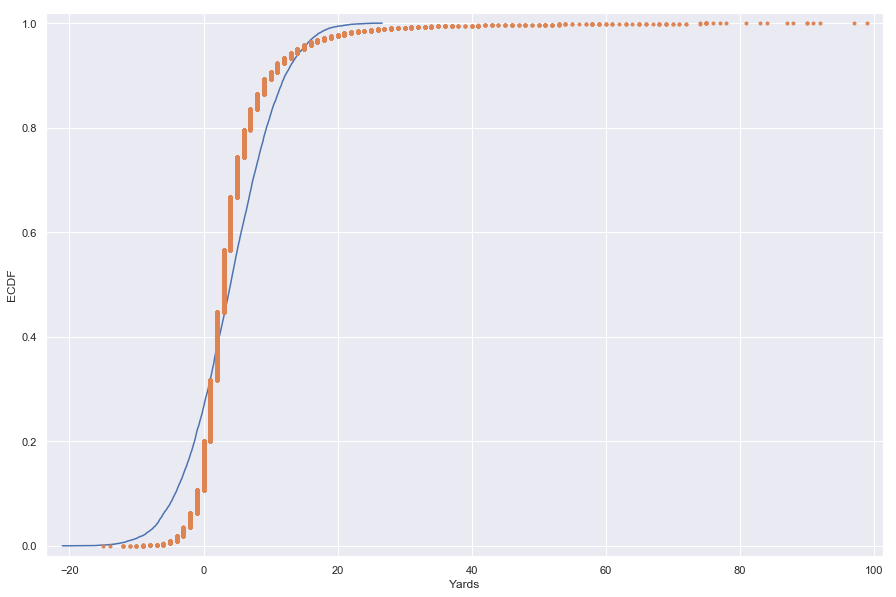

In [24]:
# Setup matplotlib
plt.rcParams["figure.figsize"] = (15,10)

plot_ecdf(plays_df, 'Yards')

In [25]:
plays_df.Yards.quantile([.25, .75])

0.25    1.0
0.75    6.0
Name: Yards, dtype: float64

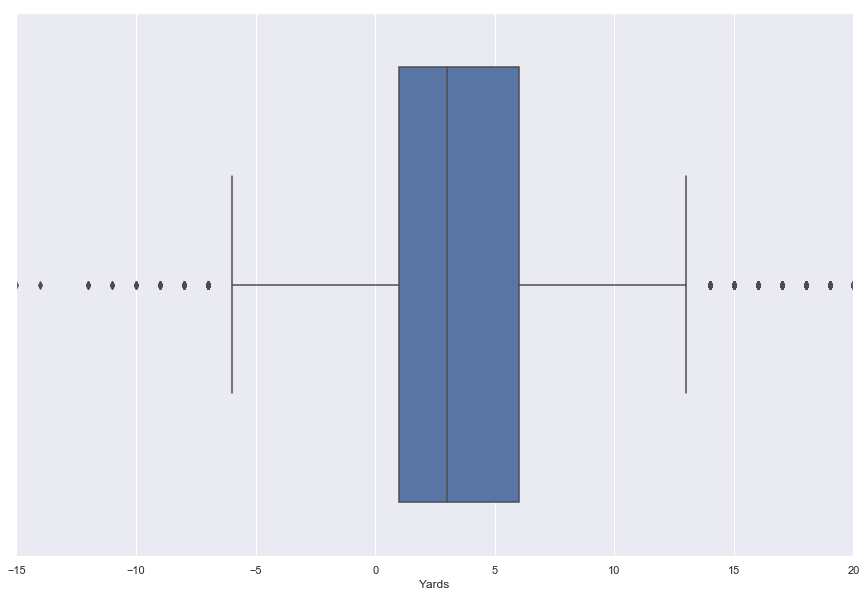

In [26]:
sns.boxplot(x='Yards', data=plays_df)
plt.xlim(-15, 20)
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\yards_dist_box.png')
plt.show()

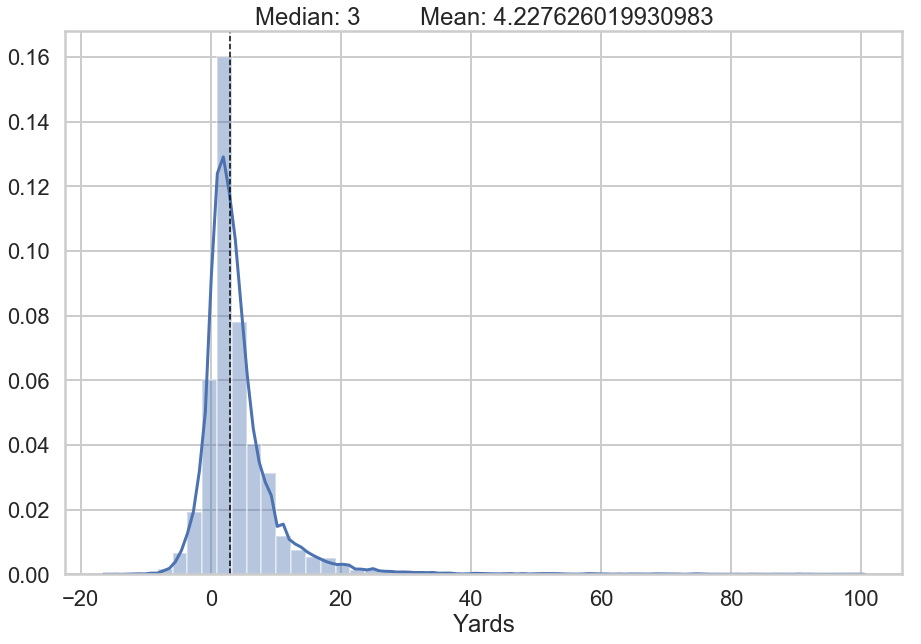

In [27]:
sns.set_style("whitegrid")
sns.set_context("poster")
sns.distplot(plays_df['Yards'])
plt.axvline(statistics.median(plays_df['Yards']), color='black', linestyle='--', linewidth=1.5, label='median')
plt.title('Median: {}'.format(statistics.median(plays_df.Yards)) + '         Mean: {}'.format(statistics.mean(plays_df.Yards)))
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\yards_dist.png')
plt.show()

### Is there a relationship between Down and Yards gained?

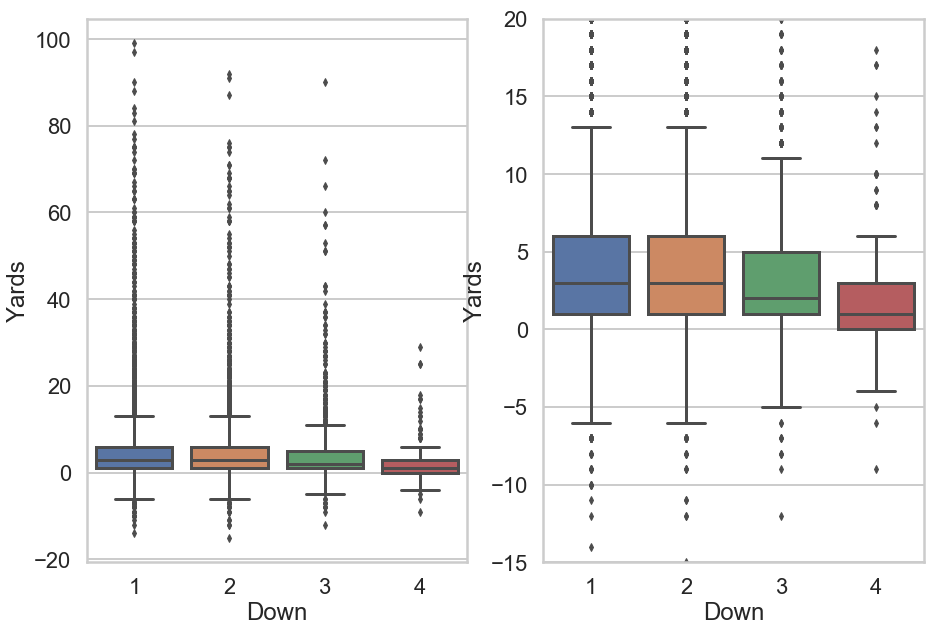

(-0.023487111661879036, 3.530992470486352e-05)

In [28]:
f, axes = plt.subplots(1,2)
sns.boxplot(x='Down', y='Yards', data=plays_df, ax=axes[0])
plt.ylim(-15, 20)
sns.boxplot(x='Down', y='Yards', data=plays_df, ax=axes[1])
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\downVSyards.png')
plt.show()

stats.pearsonr(plays_df.Down, plays_df.Yards)

* Teams gain slightly fewer yards on 3rd and 4th down. 3rd and 4th down runs usually occur when there are few yards to go. There are fewer outliers on 4th down because it is rarely attempted on one's own side of the field.

### Do home teams typically gain more yards than away teams?

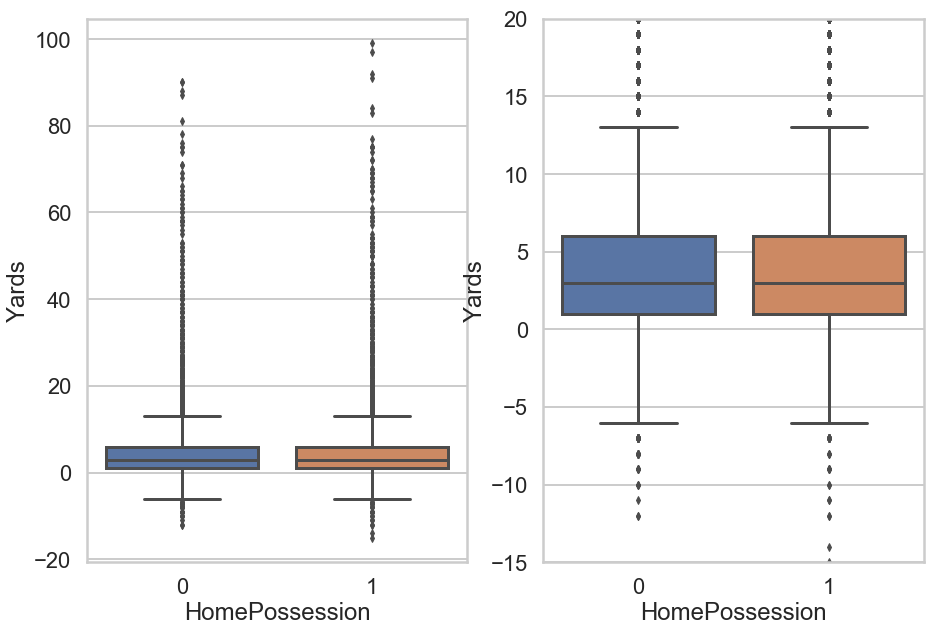

t: -1.254118722488505
prob: 0.20980831114139709


In [29]:
f, axes = plt.subplots(1,2)

sns.boxplot(x='HomePossession', y='Yards', data=plays_df, ax=axes[0])

plt.ylim(-15, 20)

sns.boxplot(x='HomePossession', y='Yards', data=plays_df, ax=axes[1])

plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\hometeamVSyards.png')
plt.show()

t, prob = stats.ttest_ind(plays_df.Yards[plays_df.HomePossession == 0], plays_df.Yards[plays_df.HomePossession == 1])
print('t: {}'.format(t))
print('prob: {}'.format(prob))

* It appears that they do not.

### Teams typically gain more yards when there are fewer defnders in the box

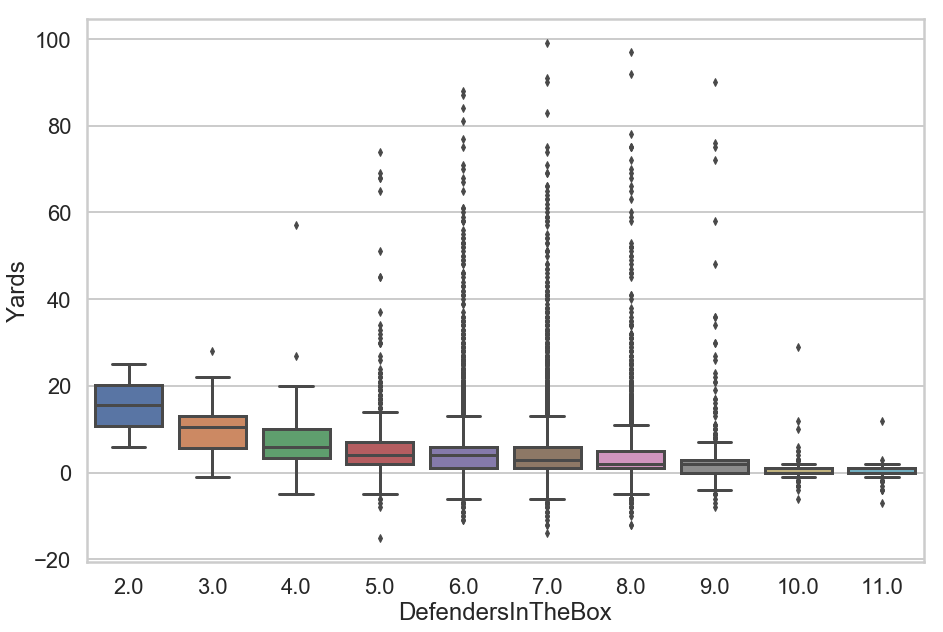

In [30]:
sns.boxplot(x='DefendersInTheBox', y='Yards', data=plays_df)
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\defendersinbox.png')
plt.show()

### Teams seem to gain the same number of yards in each quarter.

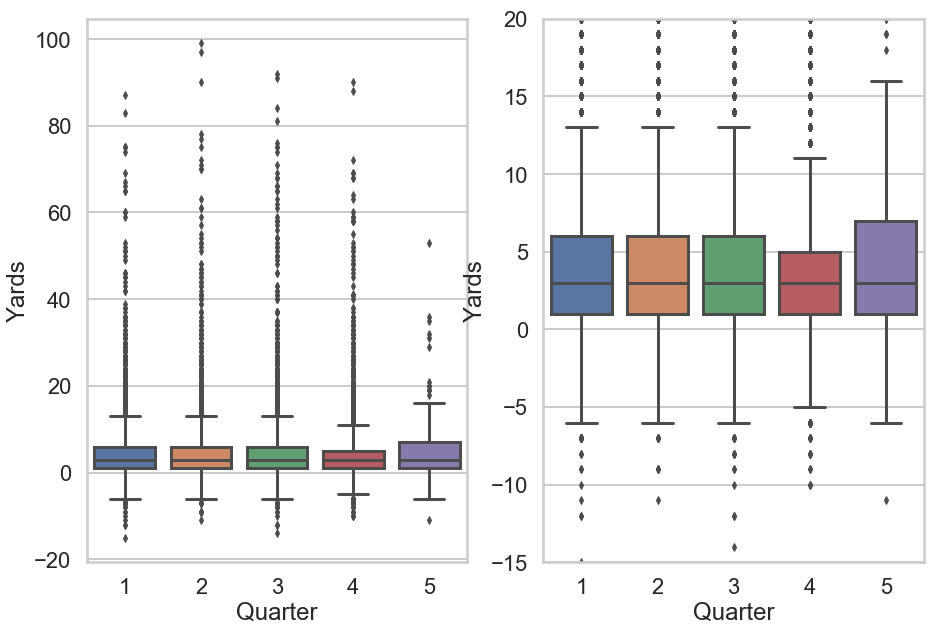

In [31]:
f, axes = plt.subplots(1,2)
sns.boxplot(x='Quarter', y='Yards', data=plays_df, ax=axes[0])
plt.ylim(-15, 20)
sns.boxplot(x='Quarter', y='Yards', data=plays_df, ax=axes[1])
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\quarterVSyards.png')
plt.show()

In [32]:
# How many carries for each position
plays_df['Position_22'].value_counts()

RB    28886
HB      923
WR      828
FB      209
QB       99
TE       48
CB       10
DT        2
G         1
DE        1
Name: Position_22, dtype: int64

### Cornerbacks get the most yards, but only have 10 carries. Wide receivers get more yards than running backs and have a decent amount of carries. Running backs get the most carries.

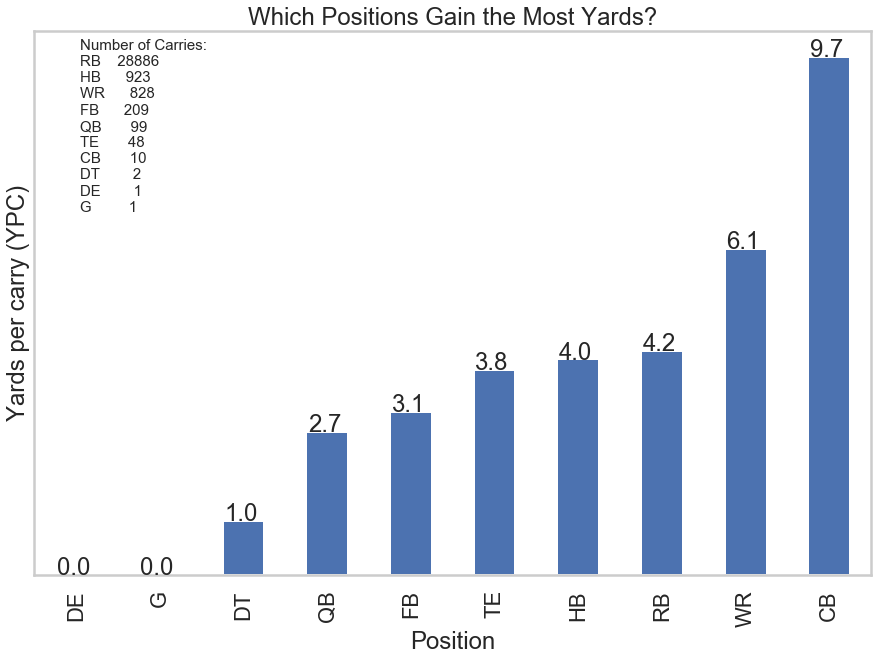

In [33]:
x = plays_df.groupby('Position_22')['Yards'].mean().sort_values()
fig, ax = plt.subplots()
x.plot(kind='bar')
plt.grid(False)
ax.set_yticks([])
plt.xlabel('Position')
plt.ylabel('Yards per carry (YPC)')
plt.text(0.05,6.8, 'Number of Carries:\nRB    28886\nHB      923\nWR      828\nFB      209\nQB       99\nTE       48\nCB       10\nDT        2\nDE        1\nG         1', size=15)
plt.title('Which Positions Gain the Most Yards?')
for i, v in enumerate(x):
    plt.text(i - 0.23, v, str(round(x[i], 1)))
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\positionVSyards.png')
plt.show()

## The New Orleans Saints gain the most yards per carry and the Tampa Bay Buccaneers gain the fewest.

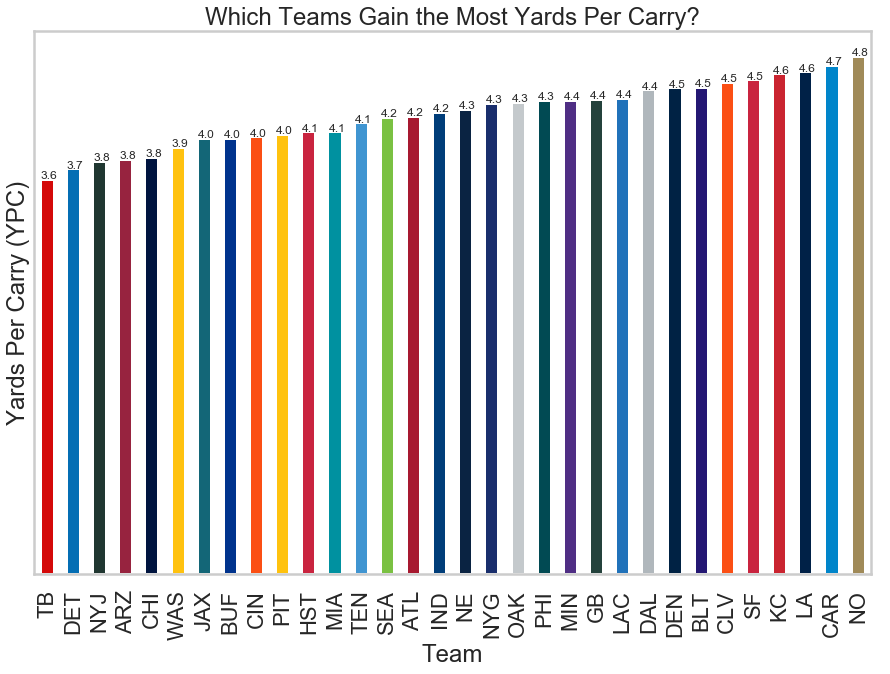

In [34]:
# Yards per carry by team
x = plays_df.groupby('PossessionTeam')['Yards'].mean().sort_values()

# Dictionary of color codes for each team
COLORS = {'ARZ':'#97233F','ATL':'#A71930','BLT':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLV':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HST':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C','NYJ':'#203731',
          'OAK':'#C4C9CC','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

# Sort the colors to be plotted in correct order
color_list = []
for team in x.index:
    color_list.append(COLORS[team])

# Plot figure
fig, ax = plt.subplots()

x.plot(kind='bar', color=color_list)
plt.grid(False)
ax.set_yticks([])
for i, v in enumerate(x):
    plt.text(i - 0.25, v + 0.01, str(round(v, 1)), size=12, rotation=0)
plt.xlabel('Team')
plt.ylabel('Yards Per Carry (YPC)')
plt.title('Which Teams Gain the Most Yards Per Carry?')
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\teamVSyards.png')
plt.show()

## How do yards correlate with the angle the runner takes?
* Runs to the outside are riskier than runs up the middle

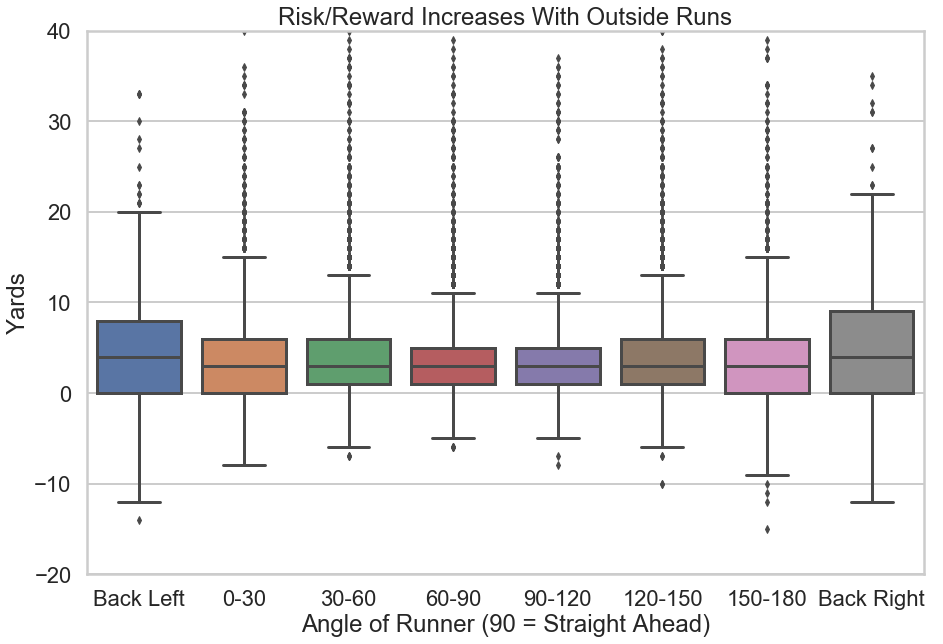

In [35]:
plays_df.loc[(plays_df['Dir_22'] >= 270) & (plays_df['Dir_22'] <= 360), 'RunningAngle'] = 'Back Left'
plays_df.loc[(plays_df['Dir_22'] >= 0) & (plays_df['Dir_22'] < 30), 'RunningAngle'] = '0-30'
plays_df.loc[(plays_df['Dir_22'] >= 30) & (plays_df['Dir_22'] < 60), 'RunningAngle'] = '30-60'
plays_df.loc[(plays_df['Dir_22'] >= 60) & (plays_df['Dir_22'] < 90), 'RunningAngle'] = '60-90'
plays_df.loc[(plays_df['Dir_22'] >= 90) & (plays_df['Dir_22'] < 120), 'RunningAngle'] = '90-120'
plays_df.loc[(plays_df['Dir_22'] >= 120) & (plays_df['Dir_22'] < 150), 'RunningAngle'] = '120-150'
plays_df.loc[(plays_df['Dir_22'] >= 150) & (plays_df['Dir_22'] < 180), 'RunningAngle'] = '150-180'
plays_df.loc[(plays_df['Dir_22'] >= 180) & (plays_df['Dir_22'] < 270), 'RunningAngle'] = 'Back Right'


sns.boxplot(x=plays_df['RunningAngle'], y=plays_df['Yards'], data=plays_df, order = ['Back Left', '0-30', '30-60', '60-90', '90-120', '120-150', '150-180', 'Back Right'])
plt.ylim(-20,40)

plt.xlabel('Angle of Runner (90 = Straight Ahead)')
plt.ylabel('Yards')
plt.title('Risk/Reward Increases With Outside Runs')
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\angleVSyards.png')
plt.show()

In [36]:
# Select the columns needed to plot a single play
X_cols = []
Y_cols = []
offense_cols = []
position_cols = []

for x in range(1,23):
    X_cols.append('X_' + str(x))
    Y_cols.append('Y_' + str(x))
    offense_cols.append('OffensePlayer_' + str(x))
    position_cols.append('Position_' + str(x))



In [38]:
# Create the dataframe needed to plot a single play
image_df = pd.DataFrame(plays_df[X_cols].iloc[0].values, columns=['X']).reset_index(drop=True)
image_df['Y'] = pd.DataFrame(plays_df[Y_cols].iloc[0]).reset_index(drop=True)
image_df['offense'] = pd.DataFrame(plays_df[offense_cols].iloc[0]).reset_index(drop=True)
image_df['Position'] = pd.DataFrame(plays_df[position_cols].iloc[0]).reset_index(drop=True)

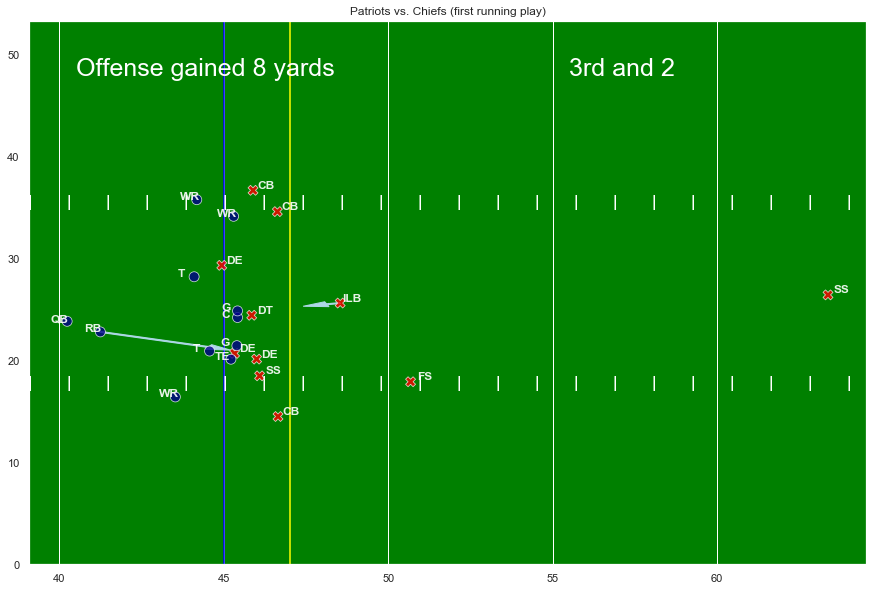

In [39]:
# Plot the play
sns.set(rc={'axes.facecolor':'green'})
plt.rc('axes', axisbelow=True)
# Plot each (x,y) coordinate with color and marker determined by offense/defense
sns.scatterplot(data=image_df, x='X', y='Y', marker='o', style='offense', style_order=[1,0], hue='offense', palette=['red', 'darkblue'], s=100, alpha=0.8, legend=False, zorder=2)
# Plot arrows for the RB and ILB representing their direction and speed
plt.arrow(image_df.X[21], image_df.Y[21], 3.28, -1.48, width=0.1, head_width=0.5, fc='lightblue', ec='lightblue')
plt.arrow(image_df.X[3], image_df.Y[3], -.404, -.113, width=0.1, head_width=0.5, fc='lightblue', ec='lightblue')

# Label the offensive players, offset to the left
for line in range(0,11):
    plt.text(image_df.X[line]+0.65, image_df.Y[line]+0.2, image_df.Position[line], horizontalalignment='right', size='medium', color='white', weight='semibold', alpha=0.9)
# Label the defensive players, offset to the right
for line in range(11,22):
    plt.text(image_df.X[line]-0.5, image_df.Y[line], image_df.Position[line], horizontalalignment='left', size='medium', color='white', weight='semibold', alpha=0.9)
    
# Set the width of the field   
plt.ylim(0,53.33)
plt.grid(b=False, axis='y')
# Generate hash marks
plt.axhline(53.33/3, color='white', linestyle='--', linewidth=15, dashes=(.1, 2.5))
plt.axhline((53.33/3)*2, color='white', linestyle='--', linewidth=15, dashes=(.1, 2.5))
# Generate the line of scrimmage and first down marker
plt.axvline(45, color='blue', zorder=1)
plt.axvline(47, color='yellow', zorder=1)

# annotate
plt.xlabel('')
plt.ylabel('')
plt.text(40.5,48, 'Offense gained 8 yards', color = 'white', size=25)
plt.text(55.5,48, '3rd and 2', color = 'white', size=25)
plt.title('Patriots vs. Chiefs (first running play)')
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\play.png')
plt.show()

In [40]:
# Check whether of Oline or Dline won the trench battle
plays_df.loc[(plays_df['MiddleOlineAvgX'] >= 1), 'TrenchBattle'] = 'Oline wins'
plays_df.loc[(plays_df['MiddleOlineAvgX'] <= -1), 'TrenchBattle'] = 'Dline wins'
plays_df.loc[(plays_df['MiddleOlineAvgX'] > -1) & (plays_df['MiddleOlineAvgX'] < 1), 'TrenchBattle'] = 'Even'

## Do teams gain more yards when the Oline gets a good push?

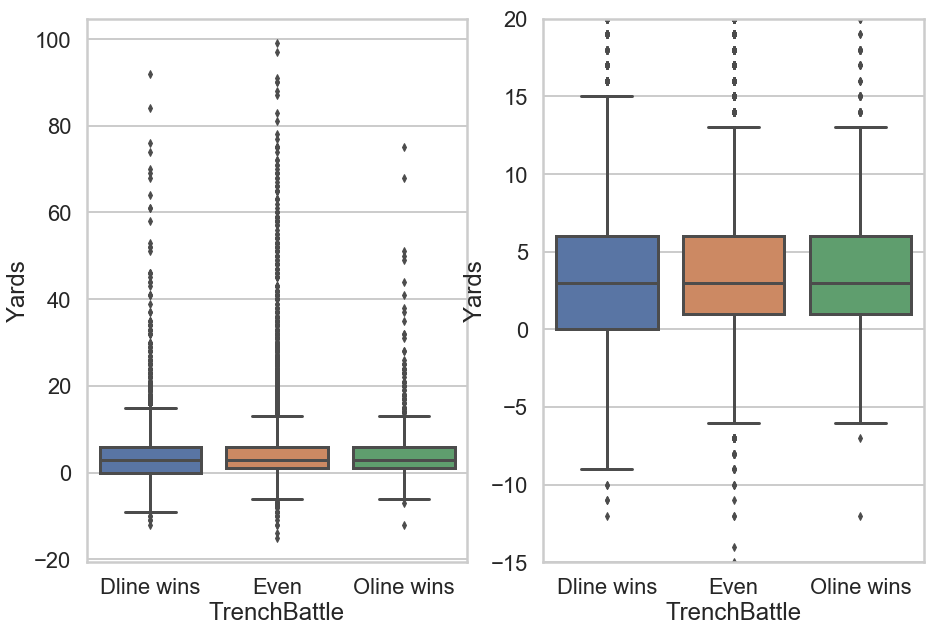

In [42]:
sns.set_style("whitegrid")
sns.set_context("poster")
f, axes = plt.subplots(1,2)
sns.boxplot(x='TrenchBattle', y='Yards', data=plays_df, order=['Dline wins', 'Even', 'Oline wins'], ax=axes[0])
plt.ylim(-15,20)
sns.boxplot(x='TrenchBattle', y='Yards', data=plays_df, order=['Dline wins', 'Even', 'Oline wins'], ax=axes[1])
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\trenchbattle3.png')
plt.show()

* When the Dline gets a push, there is more variance in yards gained.
* This is likely because sometimes the Dline overruns the play, letting the runner get to the second level.

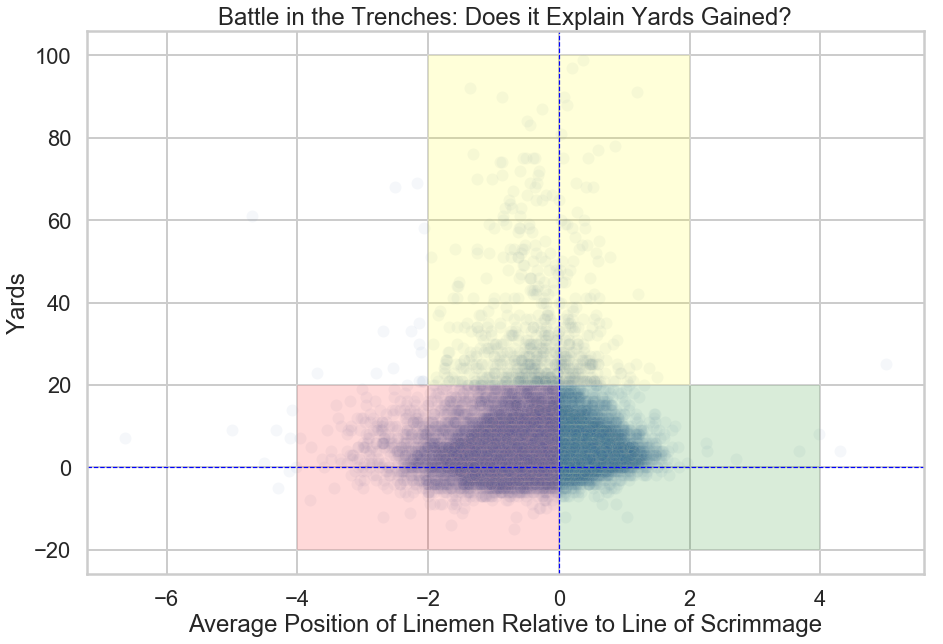

In [43]:
# A more continuous look at the trench battle
sns.set_style("whitegrid")
sns.set_context("poster")
stats.pearsonr(plays_df['OlineDlineAvgX'], plays_df['Yards'])
sns.scatterplot(x='OlineDlineAvgX', y='Yards', data=plays_df, alpha=.05)
plt.fill_between([0,4], -20, 20, facecolor='green', alpha=.15, interpolate=True)
plt.fill_between([-4,0], -20, 20, facecolor='red', alpha=.15, interpolate=True)
plt.fill_between([-2,2], 20, 100, facecolor='yellow', alpha=.15, interpolate=True)
plt.axhline(0, color='blue', linestyle='--', linewidth=1.2)
plt.axvline(0, color='blue', linestyle='--', linewidth=1.2)
plt.title('Battle in the Trenches: Does it Explain Yards Gained?')
plt.xlabel('Average Position of Linemen Relative to Line of Scrimmage')
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\TrenchBattle.png')
plt.show()

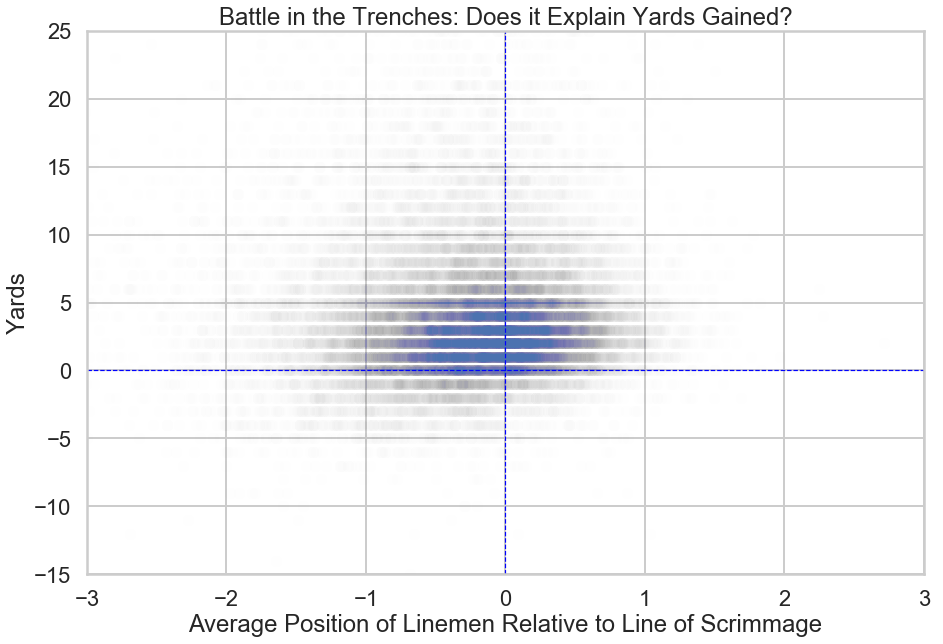

In [44]:
# A lower alpha shows where most of the data lies
sns.set_style("whitegrid")
sns.set_context("poster")
stats.pearsonr(plays_df['OlineDlineAvgX'], plays_df['Yards'])
sns.scatterplot(x='OlineDlineAvgX', y='Yards', data=plays_df, alpha=.002)
plt.axhline(0, color='blue', linestyle='--', linewidth=1.2)
plt.axvline(0, color='blue', linestyle='--', linewidth=1.2)
plt.ylim(-15,25)
plt.xlim(-3,3)
plt.title('Battle in the Trenches: Does it Explain Yards Gained?')
plt.xlabel('Average Position of Linemen Relative to Line of Scrimmage')
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\TrenchBattle2.png')
plt.show()

## Are yards correlated with the runner's acceleration at the time of handoff?

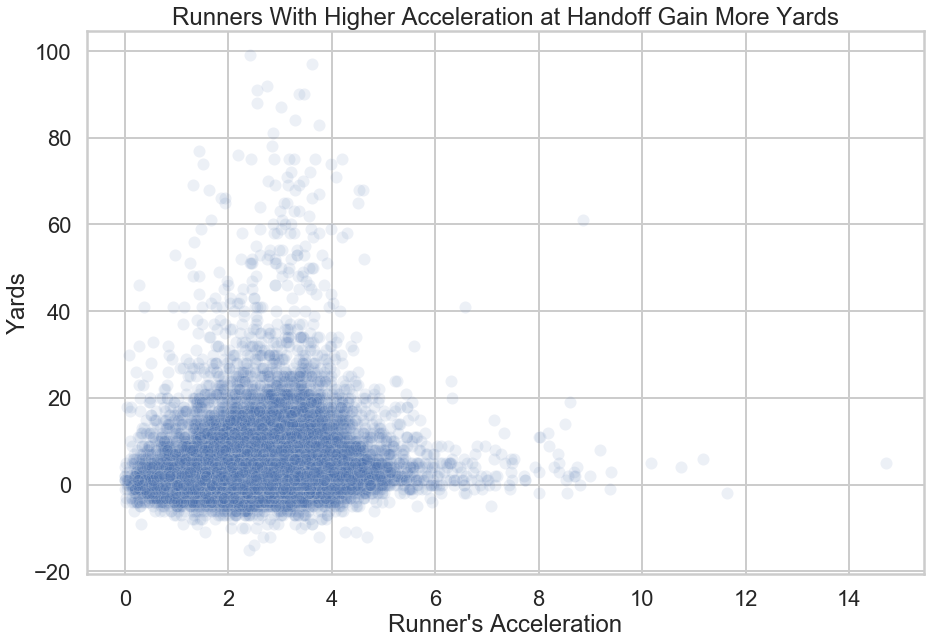

(0.13178188640158944, 3.855355770489586e-120)

In [45]:
sns.scatterplot(x='A_22', y='Yards', data=plays_df, alpha=0.1)
plt.xlabel('Runner\'s Acceleration')
plt.title('Runners With Higher Acceleration at Handoff Gain More Yards')
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\accelerationVSyards.png')
plt.show()
stats.pearsonr(plays_df.A_22, plays_df.Yards)

* Runners gain more yards when the get the ball with high acceleration

## How does age correlate with yards gained?

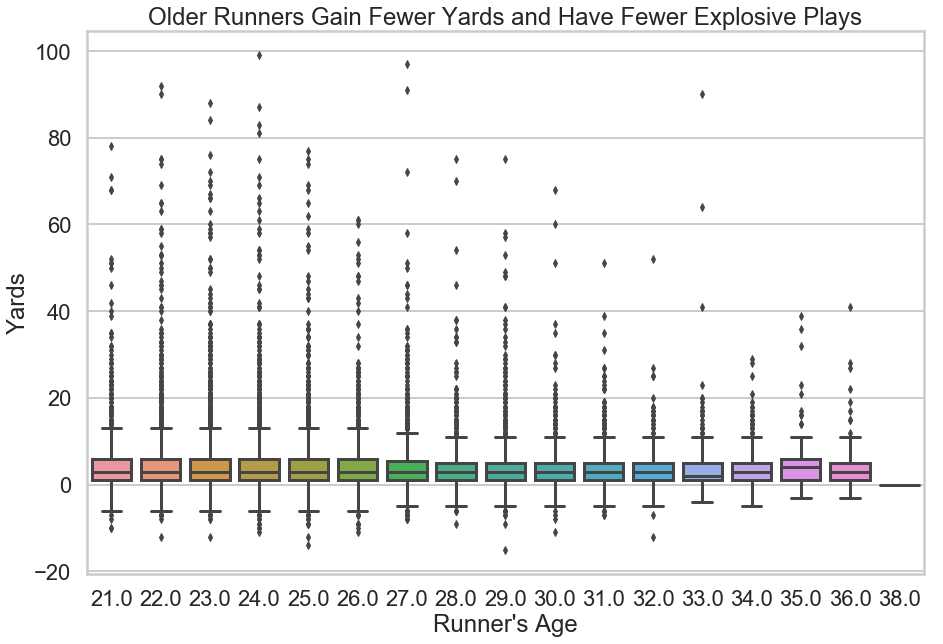

(-0.02349007487681467, 3.5229732377521114e-05)

In [46]:
# Round age down to an integer
plays_df['RoundedAge'] = plays_df['PlayerAge_22'].astype(float).apply(np.floor)


sns.boxplot(x='RoundedAge', y='Yards', data=plays_df)
plt.xlabel('Runner\'s Age')
plt.title('Older Runners Gain Fewer Yards and Have Fewer Explosive Plays')
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\ageVSyards.png')
plt.show()
stats.pearsonr(plays_df.PlayerAge_22, plays_df.Yards)

* Older runners generally get fewer yards

## Do runners gain more yards when they get the ball with more space

In [47]:
# Define a function to find the distance between two players
def distance(p1, p2):
    x1, y1 = p1[0], p1[1]
    x2, y2 = p2[0], p2[1]
    d = np.sqrt(((x2 - x1)**2) + (y2 - y1)**2)
    return d

In [48]:
# Get the columns for the (x,y) corrdinates of the runner and all defensive players
runner_and_defense_positions = []
runner_and_defense_positions.append((plays_df.X_22[0], plays_df.Y_22[0]))
for i in range(1,12):
    runner_and_defense_positions.append((plays_df['X_'+str(i)][0], plays_df['Y_'+str(i)][0]))

In [49]:
# Convert the (x,y) coordinates to numeric. Previously they were objects
cols_to_convert = []

for i in range(1,23):
    cols_to_convert.append('X_'+str(i))
    cols_to_convert.append('Y_'+str(i))
    
plays_df[cols_to_convert] = plays_df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [50]:
# Function that takes a row of data and returns the shortest distance between the runner and a defender
def closest_defender(row):
    runner_and_defense_positions = []
    runner_and_defense_positions.append((row.X_22, row.Y_22))
    for i in range(1,12):
        runner_and_defense_positions.append((row['X_'+str(i)], row['Y_'+str(i)]))
    distances = []
    for i in range(2,12):
        distances.append(distance(runner_and_defense_positions[0], runner_and_defense_positions[i]))
    
    return min(distances)

In [51]:
# Apply function to find closest defender for each row
plays_df['ClosestDefender'] = plays_df.apply(closest_defender, axis=1)

(0.04808390222694098, 2.4213015428031344e-17)

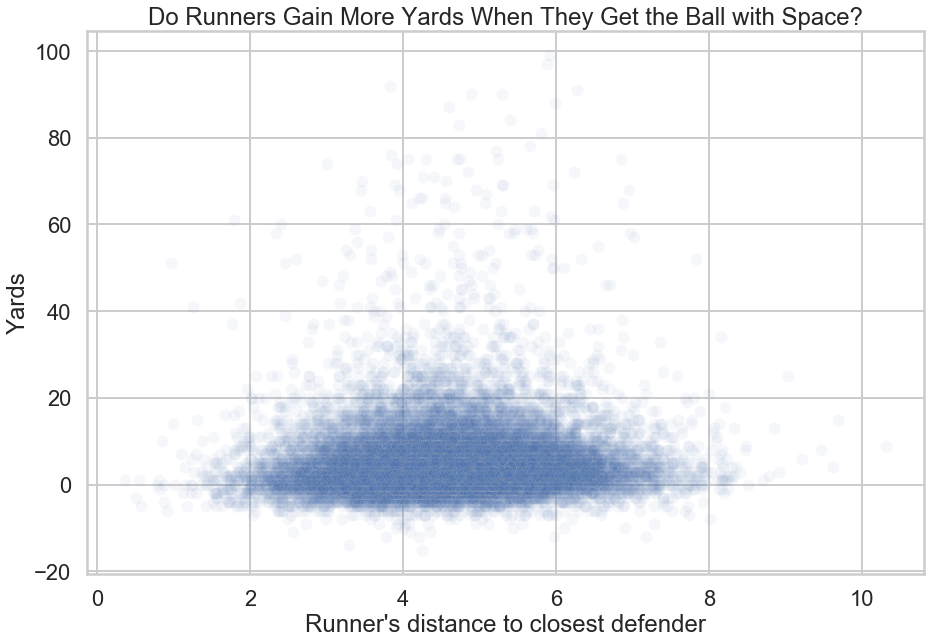

In [52]:
sns.scatterplot(x='ClosestDefender', y='Yards', data=plays_df, alpha=0.05)
plt.xlabel('Runner\'s distance to closest defender')
plt.title('Do Runners Gain More Yards When They Get the Ball with Space?')
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\closestdefenderVSyards.png')
stats.pearsonr(plays_df.ClosestDefender, plays_df.Yards)

In [54]:
# Create categorical variable for how much space the runner has at handoff
plays_df.loc[(plays_df['ClosestDefender'] >= 0) & (plays_df['ClosestDefender'] < 2), 'Space'] = 'Less than 2'
plays_df.loc[(plays_df['ClosestDefender'] >= 2) & (plays_df['ClosestDefender'] < 3), 'Space'] = '2-3'
plays_df.loc[(plays_df['ClosestDefender'] >= 3) & (plays_df['ClosestDefender'] < 4), 'Space'] = '3-4'
plays_df.loc[(plays_df['ClosestDefender'] >= 4) & (plays_df['ClosestDefender'] < 5), 'Space'] = '4-5'
plays_df.loc[(plays_df['ClosestDefender'] >= 5) & (plays_df['ClosestDefender'] < 6), 'Space'] = '5-6'
plays_df.loc[(plays_df['ClosestDefender'] >= 6) & (plays_df['ClosestDefender'] < 7), 'Space'] = '6-7'
plays_df.loc[(plays_df['ClosestDefender'] >= 7) & (plays_df['ClosestDefender'] < 8), 'Space'] = '7-8'
plays_df.loc[(plays_df['ClosestDefender'] >= 8) & (plays_df['ClosestDefender'] < 999), 'Space'] = 'More than 8'

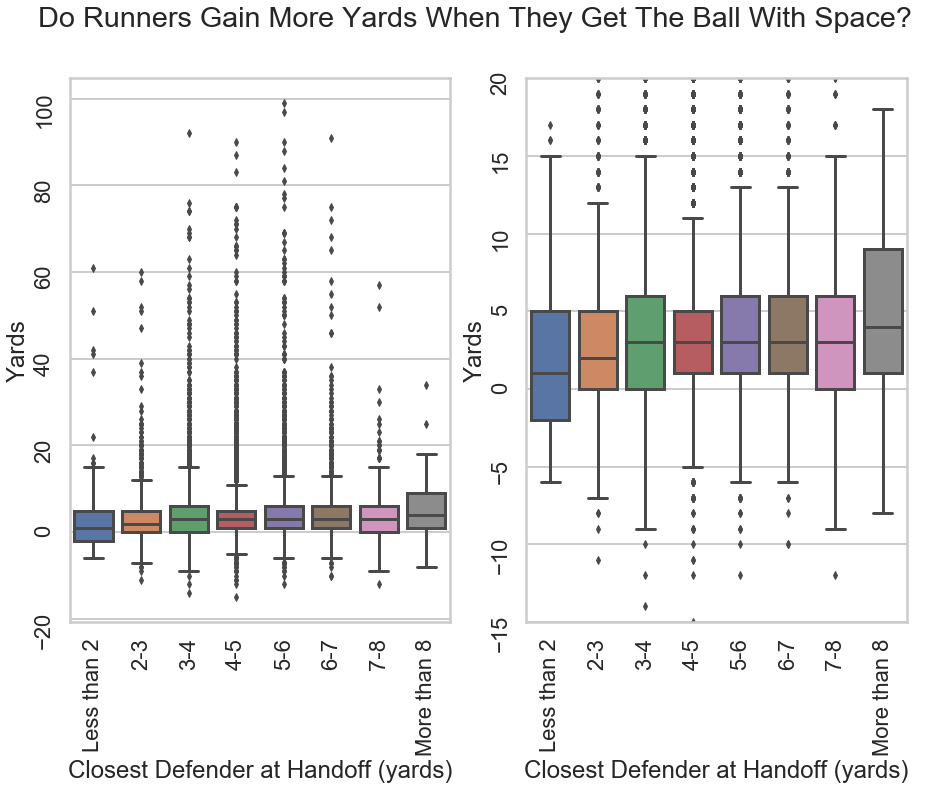

In [73]:
fig, axs = plt.subplots(1,2)

sns.boxplot(x='Space', y='Yards', data=plays_df, order=['Less than 2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', 'More than 8'], ax=axs[0])
plt.ylim(-15,20)
sns.boxplot(x='Space', y='Yards', data=plays_df, order=['Less than 2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', 'More than 8'], ax=axs[1])
axs[0].set(xlabel='Closest Defender at Handoff (yards)')
axs[1].set(xlabel='Closest Defender at Handoff (yards)')
axs[0].tick_params(labelrotation=90)
axs[1].tick_params(labelrotation=90)
fig.suptitle('Do Runners Gain More Yards When They Get The Ball With Space?')
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\spaceVSyards.png', bbox_inches='tight')
plt.show()

* This figure shows the runners generally get more yards when they receive the ball with space

## Do runners gain more yards in long distance situations?

In [70]:
# Create categorical variable for distance to first down
plays_df.loc[(plays_df['Distance'] < 5), 'DistanceCat'] = '0-5'
plays_df.loc[(plays_df['Distance'] >= 5) & (plays_df['Distance'] < 10), 'DistanceCat'] = '5-10'
plays_df.loc[(plays_df['Distance'] >= 10) & (plays_df['Distance'] < 15), 'DistanceCat'] = '10-15'
plays_df.loc[(plays_df['Distance'] >= 15) & (plays_df['Distance'] < 20), 'DistanceCat'] = '15-20'
plays_df.loc[(plays_df['Distance'] >= 20), 'DistanceCat'] = '20+'

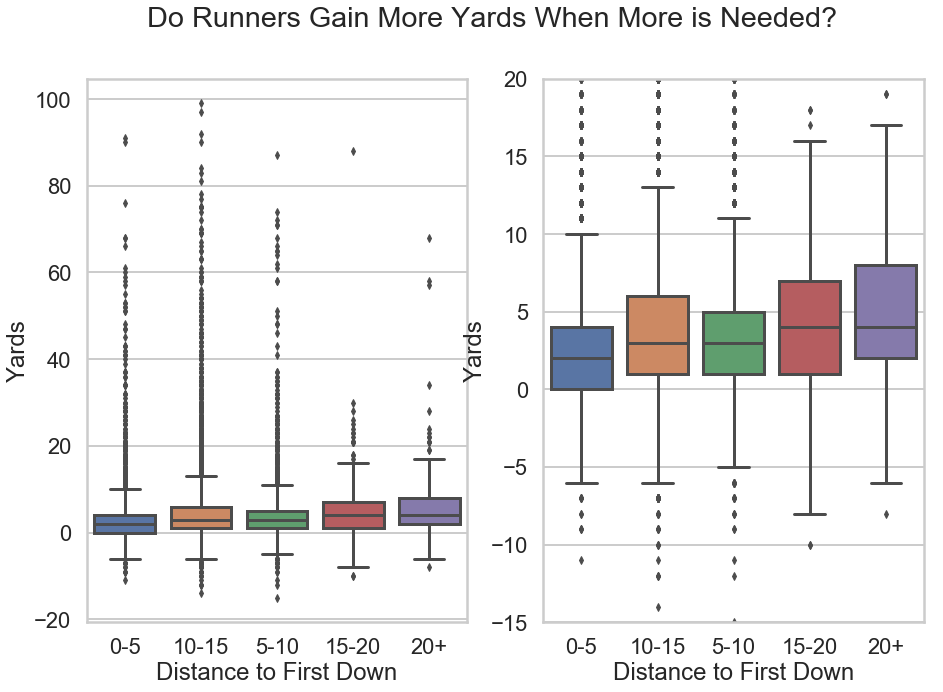

In [72]:
fig, axes = plt.subplots(1,2)
sns.boxplot(x='DistanceCat', y='Yards', data=plays_df, ax=axes[0])
plt.ylim(-15,20)
sns.boxplot(x='DistanceCat', y='Yards', data=plays_df, ax = axes[1])
axes[0].set(xlabel='Distance to First Down')
axes[1].set(xlabel='Distance to First Down')
fig.suptitle('Do Runners Gain More Yards When More is Needed?')
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\distanceVSyards.png', bbox_inches='tight')
plt.show()

* Runners tend to gain more yards in long distance situations

In [303]:
plays_df.to_csv(r'C:\Users\Evan\Desktop\Capstone_Project\plays_df.csv')